In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd /content/drive/MyDrive/PDBR/Dataset/Task_2_3

/content/drive/MyDrive/PDBR/Dataset/Task_2_3


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd 
import os
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics



# Upload features from task 1: Eyes features and spectrum compressed features

In [ ]:
# MODEL 1 DATA

train_data_m1 = pd.read_csv(os.path.join('train_data.csv')) # Same data from task 1 (no further training)
test_data_m1 = pd.read_csv(os.path.join('test_data.csv'))

x_train_m1 = train_data_m1.iloc[:, 0:]
x_test_m1 = test_data_m1.iloc[:, 0:]

# MODEL 2 DATA
pkl_file = open('training.pkl', 'rb') # Same data from task 1 (no further training)
data = pickle.load(pkl_file)
pkl_file.close()
X_m2 = data["data"]
y_m2 = data["label"]
pkl_file = open('task2.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X_test_m2= data["data"]
y_test_m2 = data["label"]

# Convert to pandas 
x_train_m2 = pd.DataFrame(X_m2)
y_train_m2 = pd.DataFrame(y_m2)

x_test_m2 = pd.DataFrame(X_test_m2)
y_test_m2 = pd.DataFrame(y_test_m2)


Both datasets ``x_train_s`` and ``x_train_j`` as well as its corresponding testing sets, containg zeros and nans, because on this specific cases, no faces were detected.

Replace these rows by the mean

In [ ]:
y_test_m1  = x_test_m1.iloc[:, 0]
y_train_m1  = x_train_m1.iloc[:, 0]

# Replace nans by mean
x_train_m1 =x_train_m1.fillna(x_train_m1.mean()) 
x_train_m2.replace(0,x_train_m2.mean(axis=0),inplace=True)

x_test_m1 =x_test_m1.fillna(x_test_m1.mean())
x_test_m2.replace(0,x_test_m2.mean(axis=0),inplace=True)

In [ ]:
print("x_train_m1: {} ".format(x_train_m1.shape))
print("x_train_m2: {} ".format(x_train_m1.shape))

print("x_train_m1: {} ".format(x_test_m1.shape))
print("x_train_m2: {} ".format(x_test_m1.shape))

x_train_m1: (760, 10) 
x_train_m2: (760, 10) 
x_train_m1: (600, 10) 
x_train_m2: (600, 10) 


# Model 1: Individual model performance

Selection of best features for model 1 (see notebook Task 1 - Model 1)

In [ ]:
x_train_m1 = x_train_m1.iloc[:, [1,2,4,6,7,8,9]]
x_test_m1  = x_test_m1.iloc[:, [1,2,4,6,7,8,9]]

In [ ]:
model1 = SVC(C=2, kernel='rbf', random_state=123,probability=True)
model1.fit(x_train_m1, y_train_m1)

y_pred1 = model1.predict(x_test_m1)

print("svc acc:  ",accuracy_score(y_test_m1, y_pred1))
print("(SVC) - AUC: ", roc_auc_score(y_test_m1, y_pred1))

svc acc:   0.545
(SVC) - AUC:  0.5449999999999999


# Model 2: Individual model performance 


In [ ]:
model2 = SVC(C=6.37, kernel='rbf', gamma=0.86,probability=True)
model2.fit(x_train_m2, y_train_m2)
y_pred2 = model2.predict(x_test_m2)

print("svc acc:  ",accuracy_score(y_test_m2, y_pred2))
print("(SVC) - AUC: ", roc_auc_score(y_test_m2, y_pred2))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svc acc:   0.525
(SVC) - AUC:  0.5345076764015964


## Fusion

Extract probabilities: 

In [ ]:
probs1 = model1.predict_proba(x_test_m1)[:, 1]
probs2 = model2.predict_proba(x_test_m2)[:, 1]

Plot probabilities for both cases. 

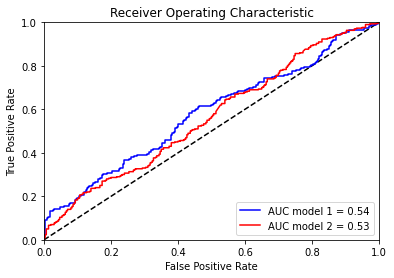

In [ ]:
fpr, tpr, threshold    = metrics.roc_curve(y_test_m2, probs2)
fpr2, tpr2, threshold2 = metrics.roc_curve(y_test_m1, probs1)


plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, 'b', label = 'AUC model 1 = %0.2f' % roc_auc_score(y_test_m1, y_pred1))
plt.plot(fpr2, tpr2, 'r', label = 'AUC model 2 = %0.2f' % roc_auc_score(y_test_m2, y_pred2))

plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.title('Receiver Operating Characteristic')
plt.show()


# Score Enssembling: Normalized scores w1,w2

In [ ]:
for w1 in np.arange(0, 1, 0.01):
  w2 = 1-w1
  total = (w1 * probs1 + w2*probs2) 
  total = np.round(total)
    
  #print("svc acc:  ",accuracy_score(total, y_test_s))
  print("(SVC) - AUC: {} using w1, w2: ({},{}) ".format(roc_auc_score(total, y_test_m1), w1,w2) )


(SVC) - AUC: 0.6017893496196293 using w1, w2: (0.0,1.0) 
(SVC) - AUC: 0.5981818181818181 using w1, w2: (0.01,0.99) 
(SVC) - AUC: 0.5981818181818181 using w1, w2: (0.02,0.98) 
(SVC) - AUC: 0.5981818181818181 using w1, w2: (0.03,0.97) 
(SVC) - AUC: 0.5981818181818181 using w1, w2: (0.04,0.96) 
(SVC) - AUC: 0.5981818181818181 using w1, w2: (0.05,0.95) 
(SVC) - AUC: 0.5981818181818181 using w1, w2: (0.06,0.94) 
(SVC) - AUC: 0.5981818181818181 using w1, w2: (0.07,0.9299999999999999) 
(SVC) - AUC: 0.5981818181818181 using w1, w2: (0.08,0.92) 
(SVC) - AUC: 0.5981818181818181 using w1, w2: (0.09,0.91) 
(SVC) - AUC: 0.5981818181818181 using w1, w2: (0.1,0.9) 
(SVC) - AUC: 0.6017893496196293 using w1, w2: (0.11,0.89) 
(SVC) - AUC: 0.6017893496196293 using w1, w2: (0.12,0.88) 
(SVC) - AUC: 0.6017893496196293 using w1, w2: (0.13,0.87) 
(SVC) - AUC: 0.609090909090909 using w1, w2: (0.14,0.86) 
(SVC) - AUC: 0.609090909090909 using w1, w2: (0.15,0.85) 
(SVC) - AUC: 0.6055594651653765 using w1, w2: (0

The best result is achieved when both weights are 0.61 and 0.39 for model 1 and model 2, respectively

In [ ]:
# Best model
w1 = 0.61
w2 = 0.39
final = (w1 * probs1 + w2*probs2) 
final_int = np.round(final)

print("svc acc:  ",accuracy_score(final_int, y_test_m1))
print("(SVC) - AUC: ", roc_auc_score(final_int, y_test_m1))

svc acc:   0.5466666666666666
(SVC) - AUC:  0.6473891072431218


### Final metrics

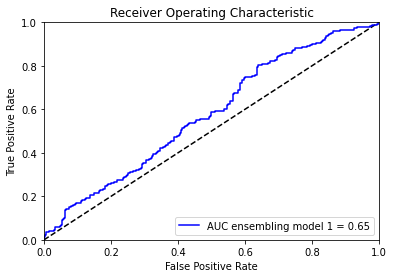

In [ ]:
fpr_final1, tpr_final1, threshold_final1    = metrics.roc_curve(y_test_m1, final)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr_final1, tpr_final1, 'b', label   = 'AUC ensembling model 1 = %0.2f' % roc_auc_score(final_int, y_test_m1))

plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()